In [6]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split


from tensorflow.keras.utils import to_categorical

from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.models import load_model
from keras.callbacks import EarlyStopping


from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes = 8
num_images = 720

In [33]:
images = []
masks = []
for i in range(num_images):
    img_path = os.path.join("/content/drive/MyDrive/raw_images/frames", f"frame_{i}.png")
    mask_path = os.path.join("/content/drive/MyDrive/raw_images/masks", f"mask_{i}.png")

    image = cv2.imread(img_path, cv2.IMREAD_COLOR).reshape(256, 256, 3)
    mask = cv2.imread(mask_path, 0)

    images.append(image)
    masks.append(mask)

image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 4)
mask_dataset = np.array(masks)

In [34]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (720, 256, 256, 3, 1)
Mask data shape is:  (720, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4 5 6 7]


In [35]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6, 7])

In [36]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(720, 256, 256, 1)


In [37]:
# Normalize images
image_dataset = image_dataset /255.

In [38]:
# Split training data
X_train, X_test, y_train, y_test = train_test_split(image_dataset,
                                                    mask_dataset_encoded,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [39]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [40]:
print(y_train_cat.shape)

(576, 256, 256, 8)


In [41]:
# Building Unet by dividing encoder and decoder into blocks

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x


#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [42]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [43]:
model = build_unet(input_shape, n_classes=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    mode='min',
    verbose=1
)

model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalizat

In [44]:
history = model.fit(X_train,
                    y_train_cat,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    callbacks=[early_stopping],
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/50
36/36 [==============================] - 80s 950ms/step - loss: 1.1007 - accuracy: 0.7865 - val_loss: 3769.8152 - val_accuracy: 0.0203
Epoch 2/50
36/36 [==============================] - 32s 899ms/step - loss: 0.5582 - accuracy: 0.8760 - val_loss: 60.6469 - val_accuracy: 0.0670
Epoch 3/50
36/36 [==============================] - 36s 993ms/step - loss: 0.4667 - accuracy: 0.8772 - val_loss: 0.7031 - val_accuracy: 0.8759
Epoch 4/50
36/36 [==============================] - 35s 982ms/step - loss: 0.4251 - accuracy: 0.8830 - val_loss: 0.6580 - val_accuracy: 0.8336
Epoch 5/50
36/36 [==============================] - 35s 987ms/step - loss: 0.3814 - accuracy: 0.8937 - val_loss: 0.8001 - val_accuracy: 0.7349
Epoch 6/50
36/36 [==============================] - 33s 917ms/step - loss: 0.3429 - accuracy: 0.9042 - val_loss: 0.7715 - val_accuracy: 0.7426
Epoch 7/50
36/36 [==============================] - 33s 916ms/step - loss: 0.3191 - accuracy: 0.9079 - val_loss: 1.5830 - val_accuracy: 0.

In [45]:
# Save the model for future use
model.save('/content/drive/MyDrive/saved_models/seg_model.keras')

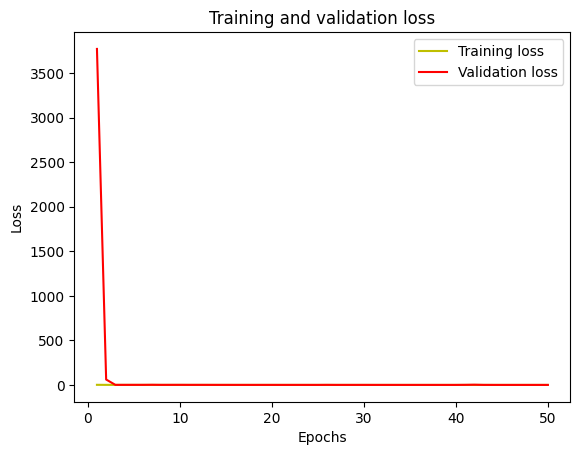

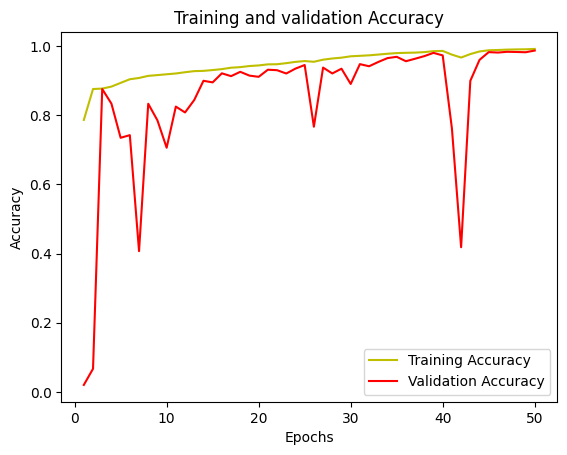

In [46]:
# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
#Load previously saved model
model = load_model("/content/drive/MyDrive/saved_models/seg_model.keras", compile=False)

In [48]:
y_pred = model.predict(X_test)

5/5 [==============================] - 21s 405ms/step


In [49]:
y_pred.shapedrive

(144, 256, 256, 8)

In [50]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(144, 256, 256)

In [51]:
#Using built in keras function

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.79895467


In [52]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)


[[8.251544e+06 3.437000e+03 3.591000e+03 2.371000e+03 1.656000e+03
  1.247000e+03 2.088000e+03 3.030000e+02]
 [2.704000e+04 5.455530e+05 4.654000e+03 5.720000e+03 1.270000e+02
  8.090000e+02 1.770000e+02 1.370000e+02]
 [6.481000e+03 2.118000e+03 2.294720e+05 1.549000e+03 1.135000e+03
  2.680000e+02 2.330000e+02 2.050000e+02]
 [1.315100e+04 2.690000e+03 1.809000e+03 1.215490e+05 5.050000e+02
  1.760000e+02 5.210000e+02 1.200000e+01]
 [5.741000e+03 6.280000e+02 7.130000e+02 8.120000e+02 7.842700e+04
  1.267000e+03 3.560000e+02 6.170000e+02]
 [5.674000e+03 1.597000e+03 1.078000e+03 7.620000e+02 4.640000e+02
  4.841000e+04 1.800000e+01 1.013000e+03]
 [2.667000e+03 6.200000e+02 1.800000e+02 1.322000e+03 3.600000e+01
  4.400000e+02 3.044900e+04 1.300000e+01]
 [3.727000e+03 3.700000e+01 2.240000e+03 1.062000e+03 3.470000e+03
  3.320000e+02 1.150000e+02 1.056900e+04]]


1/1 [==============================] - 0s 20ms/step


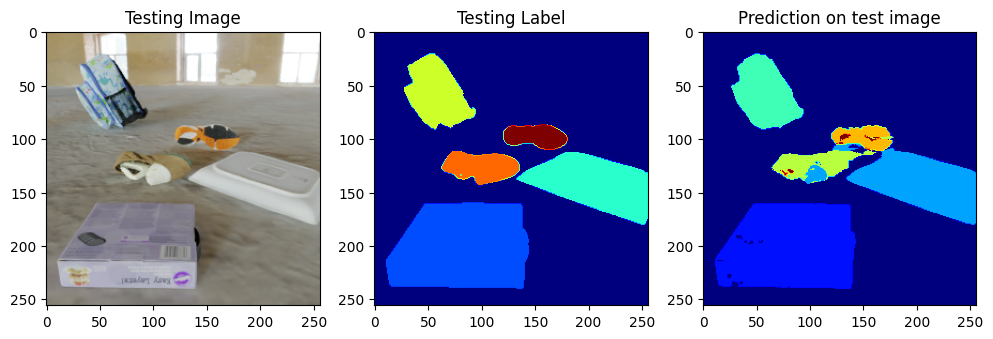

In [90]:
# Predict on a few images
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

test_img_norm = test_img[:, :, :, 0][:, :, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, :, 0])

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')

plt.show()

In [91]:
np.unique(ground_truth), np.unique(predicted_img)

(array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5, 7]))